# Testing python for spatial work

In [1]:
import geopandas as gpd
import pandas as pd
import pyproj
import shapely
import matplotlib.pyplot as plt
import pathlib

max_points_polygon =10000
tolerance = 500
n_candidates_sample = 50
random_seed = 33

def get_location():
  f_wkt = "../data/capdecreus.txt"
  location_wkt = pathlib.Path(f_wkt).read_text()
  location_wgs84 = gpd.GeoSeries(shapely.wkt.loads(location_wkt))
  location_wgs84.crs = "EPSG:4326"
  return location_wgs84

def get_sec(location):
  sec = location.geometry.minimum_bounding_circle()
  return sec

def get_centroid_wgs84(sec_wgs84):
  centroid_wgs84 = sec_wgs84.geometry.iloc[0].centroid
  pt_wgs84 = gpd.GeoSeries([centroid_wgs84])
  pt_wgs84 = gpd.GeoDataFrame(geometry = pt_wgs84)
  pt_wgs84.crs = "EPSG:4326"
  return pt_wgs84

def get_aeqd_proj(location_wgs84):
  sec_wgs84 = get_sec(location_wgs84)
  pt_wgs84 = get_centroid_wgs84(sec_wgs84)
  y, x = pt_wgs84.geometry.y.iloc[0], pt_wgs84.geometry.x.iloc[0]
  aeqd_params = {
    'proj': 'aeqd',
    'lat_0': y,
    'lon_0': x,
    'y_0': 0,
    'x_0': 0,
    '+R': '6371000',
    '+units': "m",
    'ellps': 'WGS84'
  }
  aeqd_proj = pyproj.CRS.from_dict(aeqd_params)
  return aeqd_proj

def simplify_geometry(location):
  def count_vertices(geometry):
      return len(geometry.exterior.coords)
  n = location.geometry.apply(count_vertices).iloc[0]
  if(n > max_points_polygon):
    location = location.simplify(tolerance)
  return location

def is_centroid_inside(centroid, location):
  centroid_inside = centroid.within(location)
  return centroid_inside.all()  

def get_all_vertices(location):
  df_vertices_all = location.get_coordinates()
  geometry_vertices = [shapely.geometry.Point(x, y) for x, y in zip(df_vertices_all['x'], df_vertices_all['y'])]
  gdf_vertices_all = gpd.GeoDataFrame(df_vertices_all, geometry = geometry_vertices)
  return gdf_vertices_all

def get_candidate_vertices(df_vertices_all):
  if(len(df_vertices_all) > n_candidates_sample):
    df = df_vertices_all.sample(n = n_candidates_sample, random_state = random_seed)
  else:
    df = df_vertices_all
  geometry = [shapely.geometry.Point(x, y) for x, y in zip(df['x'], df['y'])]
  gdf = gpd.GeoDataFrame(df, geometry = geometry)  
  return gdf

def get_nearest_point(centroid, location, proj):
  nearest = shapely.ops.nearest_points(centroid.geometry.iloc[0], location)[1]
  nearest.crs = proj
  centroid_coords = centroid.get_coordinates()
  nearest_coords = round(nearest.get_coordinates(), 7)
  nearest_coords_wgs84 = round(nearest.to_crs(crs="EPSG:4326").get_coordinates(),7)
  df_np = nearest.get_coordinates()
  geometry_np = [shapely.geometry.Point(x, y) for x, y in zip(df_np['x'], df_np['y'])]
  gdf_np = gpd.GeoDataFrame(df_np, geometry = geometry_np)
  return gdf_np

def get_minimum_distance_candidate(candidates, vertices):
  distance = float(4 * 10**8)
  for i in range(0, len(candidates) - 1):
    geometry = candidates.iloc[i]['geometry']
    d = max(geometry.distance(vertices['geometry']))  
    if(d < distance):
      distance = d
      idx = i
  distance = round(distance,0)
  min_d_candidate = gdf_candidates['geometry'].iloc[idx]
  return min_d_candidate, distance


CENTROID
Latitude: 42.2504520, Longitude: 3.2387080, Uncertainty: 354m


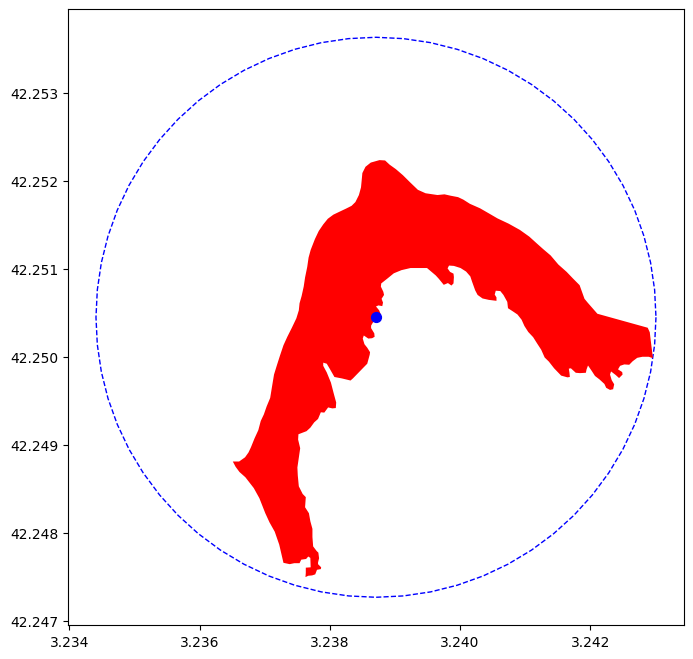

In [2]:
# Get location
location_wgs84 = get_location()

# Get SEC and centroid
sec_wgs84 = get_sec(location_wgs84)
pt_wgs84 = get_centroid_wgs84(sec_wgs84)

# Get parameterized AEQD
aeqd_proj = get_aeqd_proj(location_wgs84)

# Project to AEQD
location_aeqd = location_wgs84.to_crs(aeqd_proj)
pt_aeqd = pt_wgs84.to_crs(crs = aeqd_proj)

# Simplify geometry
location_aeqd = simplify_geometry(location_aeqd)

# Get SEC and centroid
sec_aeqd = get_sec(location_aeqd)
sec_centroid_aeqd = sec_aeqd.centroid

# vertex = shapely.geometry.Point(sec_aeqd.iloc[0].exterior.coords[0])
# center = shapely.geometry.Point(sec_centroid_aeqd.iloc[0].coords)
# radius_length = round(vertex.distance(center), 0)

centroid_inside = is_centroid_inside(pt_aeqd, location_aeqd)

if not centroid_inside: 
  # Get candidate vertices
  gdf_vertices_all = get_all_vertices(location_aeqd)
  gdf = get_candidate_vertices(gdf_vertices_all)
  # Calculate nearest point from centroid to geometry
  gdf_np = get_nearest_point(pt_aeqd, location_aeqd, aeqd_proj)
  # Add nearest point to candidate points
  gdf_candidates = pd.concat([gdf_np, gdf], ignore_index=True)
  # Get minimum distance
  candidate_fa = get_minimum_distance_candidate(gdf_candidates, gdf_vertices_all)
  centroid_fa = candidate_fa[0]
  distance = candidate_fa[1]
  # Create final SEC and centroid
  sec_centroid_aeqd = candidate_fa[0]
  distance = candidate_fa[1]
  sec_centroid_aeqd = gpd.GeoSeries(sec_centroid_aeqd)
  sec_centroid_aeqd.crs = aeqd_proj
  sec_aeqd = sec_centroid_aeqd.buffer(distance)
  sec_aeqd.crs = aeqd_proj

# Reproject back to WGS84
centroid = gpd.GeoSeries(sec_centroid_aeqd.to_crs(crs="EPSG:4326"))
sec = gpd.GeoSeries(sec_aeqd.to_crs(crs="EPSG:4326"))

# Plot result
fig, ax = plt.subplots(figsize=(8, 8))
sec.plot(facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_wgs84.plot(color = "red", ax = ax)
centroid.plot(ax = ax, color = "blue", markersize = 50, marker = "o")

# Print result
centroid.coordinates = centroid.get_coordinates()
print("CENTROID")
print(f"Latitude: {centroid.coordinates['y'].iloc[0]:.7f}, \
Longitude: {centroid.coordinates['x'].iloc[0]:.7f}, \
Uncertainty: {distance:.0f}m")
